The Inverse Distance Weighting (IDW) spatial interpolation method is used to estimate values at unknown locations based on the values of surrounding known points. The IDW method assumes that the closer a known point is to the estimation location, the greater its influence on the estimated value. The IDW method calculates the interpolated value at a given location by taking a weighted average of the values of surrounding known points, where the weights are inversely proportional to the distances between the known points and the estimation location:

$$ Z_{pred} = \frac{\sum\limits_{i=1}^n \bigg( {z_i}/{d_i^p} \bigg) }{\sum\limits_{i=1}^n \bigg( {1}/{d_i^p} \bigg)} $$

where $z_i$ is the observtion $i$ at a distance $d$ from the point of interest. The exponent $p$ dictates the relative weight of the observations as a function of distance. The higher the exponent the greater the weight to nearby observations. The exponent $p$ usually adopts a value between 1 and 2 in most software packages.

In this tutorial we will explore the inverse distance weighting method to estimate the sand content at a specific point based on known sand contents from a field sampling survey. The implementation of this formula is straight forward in Python using the Numpy module.

Other spatial interpolation methods, such as kriging, can also account for the spatial structure of field observations using a semivariogram model. We will cover kriging in the next tutorial.



In [71]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import Point


In [72]:
# Define coordiante reference systems
crs_utm = 32614 # UTM Zone 14 (good for Kansas)
crs_wgs = 4326 # WGS84

In [73]:
def interpolate_idw(x_obs,y_obs,z_obs,X_pred,Y_pred, max_dist, p=1):
    """
    Function that estimates values at unknown locations using a distance-weighted
    average of surrounding known observations.
    
    Inputs
        x_obs : x-coordinates of known observations
        y_obs : y-coordinates of known observations
        z_obs : value of observed variable
        X_pred : 1D or 2D array of x-coordinates for prediction points
        Y_pred : 1D or 2D array of y-coordinates for prediction points
    
    Returns
        1d or 2D array of estimated values
    """
        
    # Flatten arrays
    X_pred = X_pred.flatten()
    Y_pred = Y_pred.flatten()
    
    # Pre-allocate size of output array
    Z_pred = np.full_like(X_grid.flatten(), np.nan, dtype=np.double)
    
    # Iterate over each prediction point
    for n in range(X_pred.size):
        
        # Compute distance between current and all observed points
        # using Euclidean distance
        d = np.sqrt((X_pred[n] - x_obs)**2 + (Y_pred[n] - y_obs)**2)
        
        # Select only points within maximum distance
        idx = d < max_dist
        
        # Estimate value as weighted sum of neighboring observations
        Z_pred[n] = np.sum(z_obs[idx]/d[idx]**p)/np.sum(1/d[idx]**p)
     
    # Reshape Z_grid in case it has more than one dimension
    if X_grid.ndim > 1:
        Z_pred = np.reshape(Z_pred, X_grid.shape)
        
    return Z_pred

In [74]:
# Read dataset
df = pd.read_csv('../datasets/spatial/soil_texture_observations.csv')

# Convert Dataframe into geoDataframe
gdf = gpd.GeoDataFrame(df)
gdf.head(3)

,latitude,longitude,sand,clay,L,a,b,textural_class
0,38.71337,-97.43272,29.5,25.2,40.4,5.1,10.6,Loam
1,38.71386,-97.43394,44.4,17.5,46.0,7.9,15.6,Loam
2,38.71342,-97.43600,47.5,12.5,46.3,7.7,15.3,Loam


In [75]:
# Read field boundaries
bnd_gdf = gpd.read_file('../datasets/spatial/Mortimers/mortimer_bnd.geojson')
bnd_gdf

,geometry
0,"POLYGON ((-97.43696 38.71800, -97.43692 38.714..."


In [76]:
# Add Point geometry from lat and long values
gdf['points'] = gpd.points_from_xy(gdf['longitude'], gdf['latitude'])
gdf.set_geometry('points', drop=True, inplace=True, crs=crs_wgs)
gdf.head(3)


,latitude,longitude,sand,clay,L,a,b,textural_class,geometry
0,38.71337,-97.43272,29.5,25.2,40.4,5.1,10.6,Loam,POINT (-97.43272 38.71337)
1,38.71386,-97.43394,44.4,17.5,46.0,7.9,15.6,Loam,POINT (-97.43394 38.71386)
2,38.71342,-97.43600,47.5,12.5,46.3,7.7,15.3,Loam,POINT (-97.43600 38.71342)


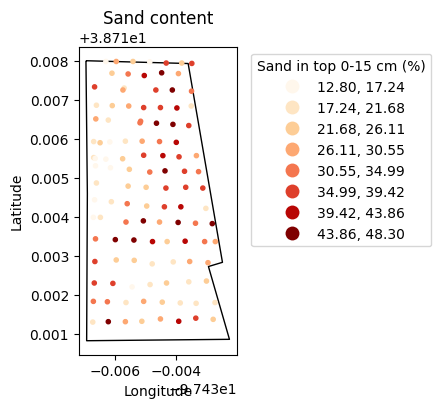

In [77]:
# Inspect spatial data
plt.figure(figsize=(5,4))
plt.title('Sand content')
bnd_gdf.plot(ax=plt.gca(), facecolor='None')
gdf.plot(ax=plt.gca(), marker='.', column='sand', cmap='OrRd',
         scheme='equal_interval', k=8, legend=True,
         legend_kwds={'loc':'upper left', 
                      'bbox_to_anchor':(1.05,1), 
                      'title':'Sand in top 0-15 cm (%)'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [78]:
# Convert point coordinates to UTM, 
# so that we can work in meters to compute distances
gdf.to_crs(crs=crs_utm, inplace=True)
bnd_gdf.to_crs(crs=crs_utm, inplace=True)


In [79]:
# Get x and y coordinates from Point geometry
x = gdf['geometry'].x.values
y = gdf['geometry'].y.values

# Get value of interpolation variable
z = gdf['sand'].values


In [80]:
# Get min and max x and y coordinates from field boundary
x_min, y_min, x_max, y_max = bnd_gdf.bounds.iloc[0]

# Generate grid
x_vec = np.linspace(x_min, x_max, num=100)
y_vec = np.linspace(y_min, y_max, num=100)

# Create grid
X_grid, Y_grid = np.meshgrid(x_vec, y_vec)


In [81]:
# Create Point geometry for all grid points
grid_points = [Point(px,py) for px,py in zip(X_grid.flatten(), Y_grid.flatten())]

# Create array of all False values
inpoly = np.full_like(grid_points, False, dtype=bool)

# Iterate over each point in the grid 
# and determine if inside field boundary
for k,p in enumerate(grid_points):
    inpoly[k] = bnd_gdf.contains(p).values[0]
    
# Restore shape of the output to match Z_grid
# We can use X_grid or Y_grid to get the shape
inpoly = np.reshape(inpoly, X_grid.shape)


In [88]:
# Interpolate using IDW
Z_grid_p1 = interpolate_idw(x, y, z, X_grid, Y_grid, max_dist=150)
Z_grid_p2 = interpolate_idw(x, y, z, X_grid, Y_grid, max_dist=150, p=2)

# Set values outside the convex hull as NaN (will render white)
Z_grid_p1[~inpoly] = np.nan
Z_grid_p2[~inpoly] = np.nan


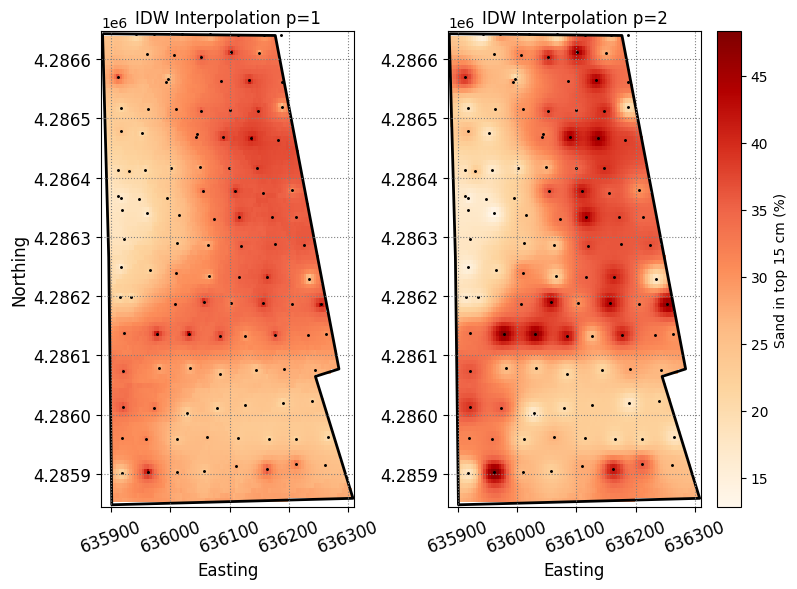

In [89]:
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
plt.title('IDW Interpolation p=1')
p1 = plt.pcolormesh(X_grid, Y_grid, Z_grid_p1, 
               cmap='OrRd', vmin=z.min(), vmax=z.max())
plt.scatter(x, y, color='k', marker='.', s=5)
bnd_gdf.plot(ax=plt.gca(), facecolor='None', linewidth=2)
#plt.axis("equal")
plt.xlabel('Easting',fontsize=12)
plt.ylabel('Northing',fontsize=12)
plt.xticks(fontsize=12, rotation=20)
plt.yticks(fontsize=12)
plt.grid(color='grey', linestyle=':')
plt.tight_layout()


plt.subplot(1,2,2)
plt.title('IDW Interpolation p=2')
p2 = plt.pcolormesh(X_grid, Y_grid, Z_grid_p2, 
               cmap='OrRd', vmin=z.min(), vmax=z.max())
plt.scatter(x, y, color='k', marker='.', s=5)
bnd_gdf.plot(ax=plt.gca(), facecolor='None', linewidth=2)
plt.colorbar(p2, label='Sand in top 15 cm (%)')
#plt.axis("equal")
plt.xlabel('Easting', fontsize=12)
plt.xticks(fontsize=12, rotation=20)
plt.yticks(fontsize=12)
plt.grid(color='grey', linestyle=':')
plt.tight_layout()

plt.show()


Our interpolations revealed concentric areas around observation points. This phenomenon is commonly called "bulls eye" (since it resembles the pattern of a bull's eye target) and is the main disadvantage of the IDW method. The "bulls eye" effect is an unfortunate artifact of IDW interpolation. This occurs due to the interpolation method's inability to adequately capture the spatial variation of the underlying variable, which is often exacerbated by greater values of the *p* parameter and sparse observations. One option to mitigate this issue is to increase the sampling density or alternatively to use smaller values of *p*. For instance, try using a value of $p = 0.5$ in one of the previous maps.